In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import numpy as np
import arviz as az


In [2]:
df = pd.read_csv("~/Thomson Lab Dropbox/David Larios/activedrops/main/102224-k401-kif3_titrations-RT/output_data/merged_expression_PIV.csv")

# Assuming df is your DataFrame
# Find rows where the condition contains an underscore
df = df[df['condition'].str.contains('_')]

# Extract motor protein type
df['motor'] = df['condition'].apply(lambda x: x.split('_')[0])

# Extract DNA concentration
df['DNA'] = df['condition'].apply(
    lambda x: float(x.split('-')[0].split('_')[1].replace('nM', '').replace('p', '.'))
)

# Add replicate column with default value 1
df['replicate'] = 1

# Find rows where the condition has a third entry when split by "_"
has_third_entry = df['condition'].apply(lambda x: len(x.split('_')) > 2)

# Parse replicate from third entry when split by "_"
df.loc[has_third_entry, 'replicate'] = df.loc[has_third_entry, 'condition'].apply(
    lambda x: int(x.split('_')[2].replace('-RT', ''))
)

# keep only the replicate 1
df = df[df['replicate'] == 1]

# rename the column 'protein Concentration_nM' to 'prot'
df.rename(columns={'Protein Concentration_nM': 'prot'}, inplace=True)
df

,condition,subcondition,time (s),Time_min,Time_h,Mean Intensity,Protein Concentration_ng_ul,prot,Number of Protein Molecules,Rate of Change of Protein Molecules per Second,...,vector direction [degrees]_mean,correlation length [m]_mean,distance [m]_mean,power [W]_mean,work [J]_mean,time (min),time (h),motor,DNA,replicate
0,K401_0p625nM-RT,Rep1,0,0.000000,0.000000,10.795248,1.376854,30.630794,3.675695e+10,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,K401,0.625,1
1,K401_0p625nM-RT,Rep1,60,1.000000,0.016667,10.763086,1.372752,30.539536,3.664744e+10,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,K401,0.625,1
2,K401_0p625nM-RT,Rep1,120,2.000000,0.033333,10.526032,1.342518,29.866912,3.584029e+10,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,K401,0.625,1
3,K401_0p625nM-RT,Rep1,180,3.000000,0.050000,10.755514,1.371786,30.518051,3.662166e+10,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,K401,0.625,1
4,K401_0p625nM-RT,Rep1,240,4.000000,0.066667,10.683785,1.362638,30.314526,3.637743e+10,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,K401,0.625,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56755,Kif3_160nM_1-RT,Rep1,14360,239.333333,3.988889,42.000890,1.532303,23.793517,2.855222e+10,1.662010e+06,...,26.710275,NaN,0.000630,NaN,NaN,239.333333,3.988889,Kif3,160.000,1
56756,Kif3_160nM_1-RT,Rep1,14368,239.466667,3.991111,42.043990,1.533875,23.817933,2.858152e+10,1.481882e+06,...,-8.135391,NaN,0.000631,NaN,NaN,239.466667,3.991111,Kif3,160.000,1
56757,Kif3_160nM_1-RT,Rep1,14376,239.600000,3.993333,42.036164,1.533589,23.813500,2.857620e+10,1.823129e+06,...,-32.874102,NaN,0.000632,NaN,NaN,239.600000,3.993333,Kif3,160.000,1
56758,Kif3_160nM_1-RT,Rep1,14384,239.733333,3.995556,41.967776,1.531094,23.774758,2.852971e+10,2.907856e+06,...,25.647536,NaN,0.000632,NaN,NaN,239.733333,3.995556,Kif3,160.000,1


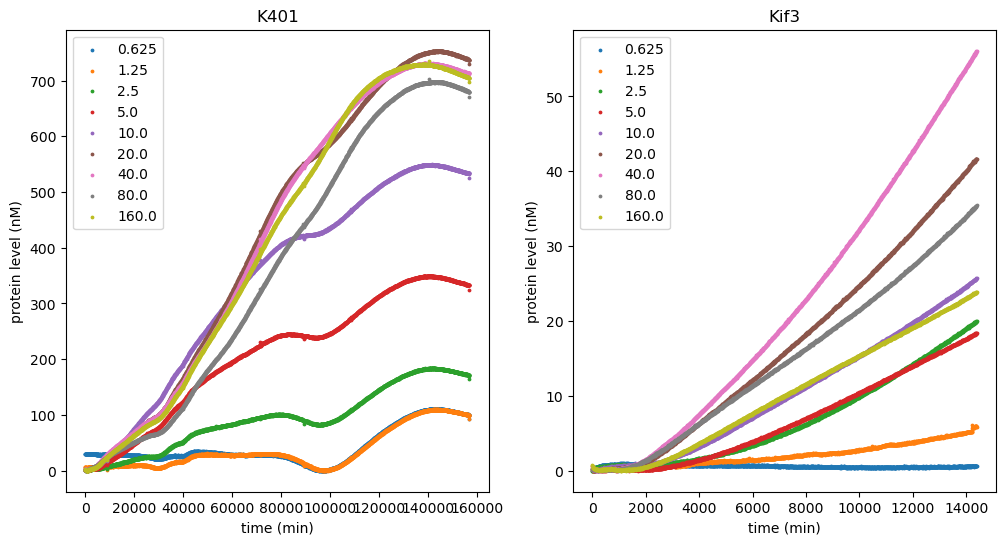

In [3]:
# Assuming df is your DataFrame and it has columns 'time', 'prot', 'DNA', and 'motor'

# Initialize figure
fig, (ax_k401, ax_kif3a) = plt.subplots(1, 2, figsize=(12, 6))

# Set axis properties for K401
ax_k401.set_xlabel("time (min)")
ax_k401.set_ylabel("protein level (nM)")
ax_k401.set_title("K401")

# Set axis properties for Kif3a
ax_kif3a.set_xlabel("time (min)")

ax_kif3a.set_ylabel("protein level (nM)")
ax_kif3a.set_title("Kif3")

# Group data by 'DNA' and 'motor'
df_group = df[df['replicate'] == 1].groupby(['DNA', 'motor'])

# Loop over groups
for (name, group) in df_group:
    # Get DNA and motor
    DNA, motor = name

    # Check which axis to use
    ax = ax_k401 if motor == "K401" else ax_kif3a

    # Plot data
    ax.scatter(group['time (s)'], group['prot'], label=f"{DNA}", s=3)

# Show legend
ax_k401.legend()
ax_kif3a.legend()

# Display the figure
plt.show()

# Bayesian inference for expression dynamics

In this notebook, we will explore a simple Bayesian model to infer the
parameters of an *in-vitro* gene expression system. The model we derived takes
the form
$$
p(t) = \frac{\kappa}{\gamma_m^2}D 
\left(e^{-\gamma_m t} -1 + \gamma_m t\right),
\tag{1}
$$
where $p(t)$ is the protein level at time $t$, $\kappa$ is the effective
transcription-translation rate, $\gamma_m$ is the mRNA degradation rate, and
$D$ is the DNA concentration.

Let's begin defining a function to compute the expected protein level at time
$t$


In [4]:
def p(t, kappa, gamma_m, D):
    """
    Compute the expected protein level at time `t` given the parameters `kappa`, `gamma_m`,
    and `D`.

    Arguments:
    - t: Time point.
    - kappa: Effective transcription-translation rate.
    - gamma_m: mRNA degradation rate.
    - D: DNA concentration.

    Returns:
    - Protein level at time `t`.
    """
    return (kappa / gamma_m**2) * D * (np.exp(-gamma_m * t) - 1 + gamma_m * t)

Now let's plot the expected protein level at time $t$ for different values of
the parameters using an interactive plot. The units here are arbitrary, since
we're just exploring the model.



In [5]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider
import matplotlib.pyplot as plt

# Define the function to compute protein levels
def p(t, kappa, gamma_m, D):
    return (kappa / gamma_m**2) * D * (np.exp(-gamma_m * t) - 1 + gamma_m * t)

# Define the interactive plotting function
def interactive_plot(kappa=1.0, gamma_m=1.0, D=1.0):
    # Define range of time points
    t = np.linspace(0, 10, 100)

    # Compute expected protein level
    prot = p(t, kappa, gamma_m, D)

    # Initialize figure
    fig, ax = plt.subplots(figsize=(5, 4))

    # Set axis labels
    ax.set_xlabel("time (a.u.)")
    ax.set_ylabel("protein level (a.u.)")

    # Plot expected protein level
    ax.plot(t, prot)

    # Set y-axis limits
    ax.set_ylim(bottom=-0.1)

    # Display the figure
    plt.show()

# Create sliders for the parameters
kappa_slider = FloatSlider(value=1.0, min=0.1, max=5.0, step=0.1, description='κ')
gamma_m_slider = FloatSlider(value=1.0, min=0.1, max=5.0, step=0.1, description='γₘ')
D_slider = FloatSlider(value=1.0, min=0.1, max=5.0, step=0.1, description='D')

# Use interact to create the interactive plot
interact(interactive_plot, kappa=kappa_slider, gamma_m=gamma_m_slider, D=D_slider)

interactive(children=(FloatSlider(value=1.0, description='κ', max=5.0, min=0.1), FloatSlider(value=1.0, descri…

<function __main__.interactive_plot(kappa=1.0, gamma_m=1.0, D=1.0)>

In [6]:
# Define columns to keep
keep_cols = ['condition', 'Time_min', 'prot', 'motor', 'DNA', 'replicate']

# Keep columns
df = df[keep_cols]

df

,condition,Time_min,prot,motor,DNA,replicate
0,K401_0p625nM-RT,0.000000,30.630794,K401,0.625,1
1,K401_0p625nM-RT,1.000000,30.539536,K401,0.625,1
2,K401_0p625nM-RT,2.000000,29.866912,K401,0.625,1
3,K401_0p625nM-RT,3.000000,30.518051,K401,0.625,1
4,K401_0p625nM-RT,4.000000,30.314526,K401,0.625,1
...,...,...,...,...,...,...
56755,Kif3_160nM_1-RT,239.333333,23.793517,Kif3,160.000,1
56756,Kif3_160nM_1-RT,239.466667,23.817933,Kif3,160.000,1
56757,Kif3_160nM_1-RT,239.600000,23.813500,Kif3,160.000,1
56758,Kif3_160nM_1-RT,239.733333,23.774758,Kif3,160.000,1


## Bayesian inference

We are now ready to fit the model to the data. We will use a simple Bayesian
model of the following form:

**Priors**

$$
\gamma_m \sim \text{Gamma}(\alpha_\gamma, \beta_\gamma),
\tag{2}
$$
and
$$
\kappa \sim \text{Gamma}(\alpha_\kappa, \beta_\kappa),
\tag{3}
$$
and
$$
\sigma_p \sim \text{Half}-\mathcal{N}(0, \sigma_p^\text{max}).
\tag{4}
$$

**Likelihood**

$$
p(t_i) \mid \gamma_m, \kappa, \sigma_p, t_i \sim
\mathcal{N}(p(t_i, \kappa, \gamma_m, D), \sigma_p^2).
\tag{5}
$$


In [7]:
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

In [8]:
# grab values for kif3 motor where DNA is 160 nM
df_kif3_160 = df.loc[(df['motor'] == 'Kif3') & (df['DNA'] == 160)]
df_kif3_160

,condition,Time_min,prot,motor,DNA,replicate
54960,Kif3_160nM_1-RT,0.000000,0.753796,Kif3,160.0,1
54961,Kif3_160nM_1-RT,0.133333,0.625660,Kif3,160.0,1
54962,Kif3_160nM_1-RT,0.266667,0.551866,Kif3,160.0,1
54963,Kif3_160nM_1-RT,0.400000,0.404352,Kif3,160.0,1
54964,Kif3_160nM_1-RT,0.533333,0.364002,Kif3,160.0,1
...,...,...,...,...,...,...
56755,Kif3_160nM_1-RT,239.333333,23.793517,Kif3,160.0,1
56756,Kif3_160nM_1-RT,239.466667,23.817933,Kif3,160.0,1
56757,Kif3_160nM_1-RT,239.600000,23.813500,Kif3,160.0,1
56758,Kif3_160nM_1-RT,239.733333,23.774758,Kif3,160.0,1


In [49]:
# Ensure data types are correct
prot = df_kif3_160['prot'].astype(float).values
t = df_kif3_160['Time_min'].astype(float).values
DNA = float(160)  # Ensure DNA is a single float value

# Define the model
with pm.Model() as bayesian_drops:
    # Define priors
    gamma_m = pm.Gamma("gamma_m", alpha=2.0, beta=0.1)
    kappa = pm.Gamma("kappa", alpha=2.0, beta=0.1)
    sigma_p = pm.TruncatedNormal("sigma_p", mu=0.0, sigma=10.0, lower=0.0)

    # Define likelihood using pm.Normal
    pm.Normal(
        "prot",
        mu=p(t, kappa, gamma_m, DNA),
        sigma=sigma_p,
        observed=prot
    )

    # Inference with burn-in (tune) steps
    idata = pm.sample(
        draws=3000,        # Number of samples to draw after tuning
        tune=1000,         # Number of tuning (burn-in) steps
        chains=4,          # Number of independent chains
        random_seed=RANDOM_SEED
    )


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gamma_m, kappa, sigma_p]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 8 seconds.


array([[<Axes: title={'center': 'gamma_m'}>,
        <Axes: title={'center': 'gamma_m'}>],
       [<Axes: title={'center': 'kappa'}>,
        <Axes: title={'center': 'kappa'}>],
       [<Axes: title={'center': 'sigma_p'}>,
        <Axes: title={'center': 'sigma_p'}>]], dtype=object)

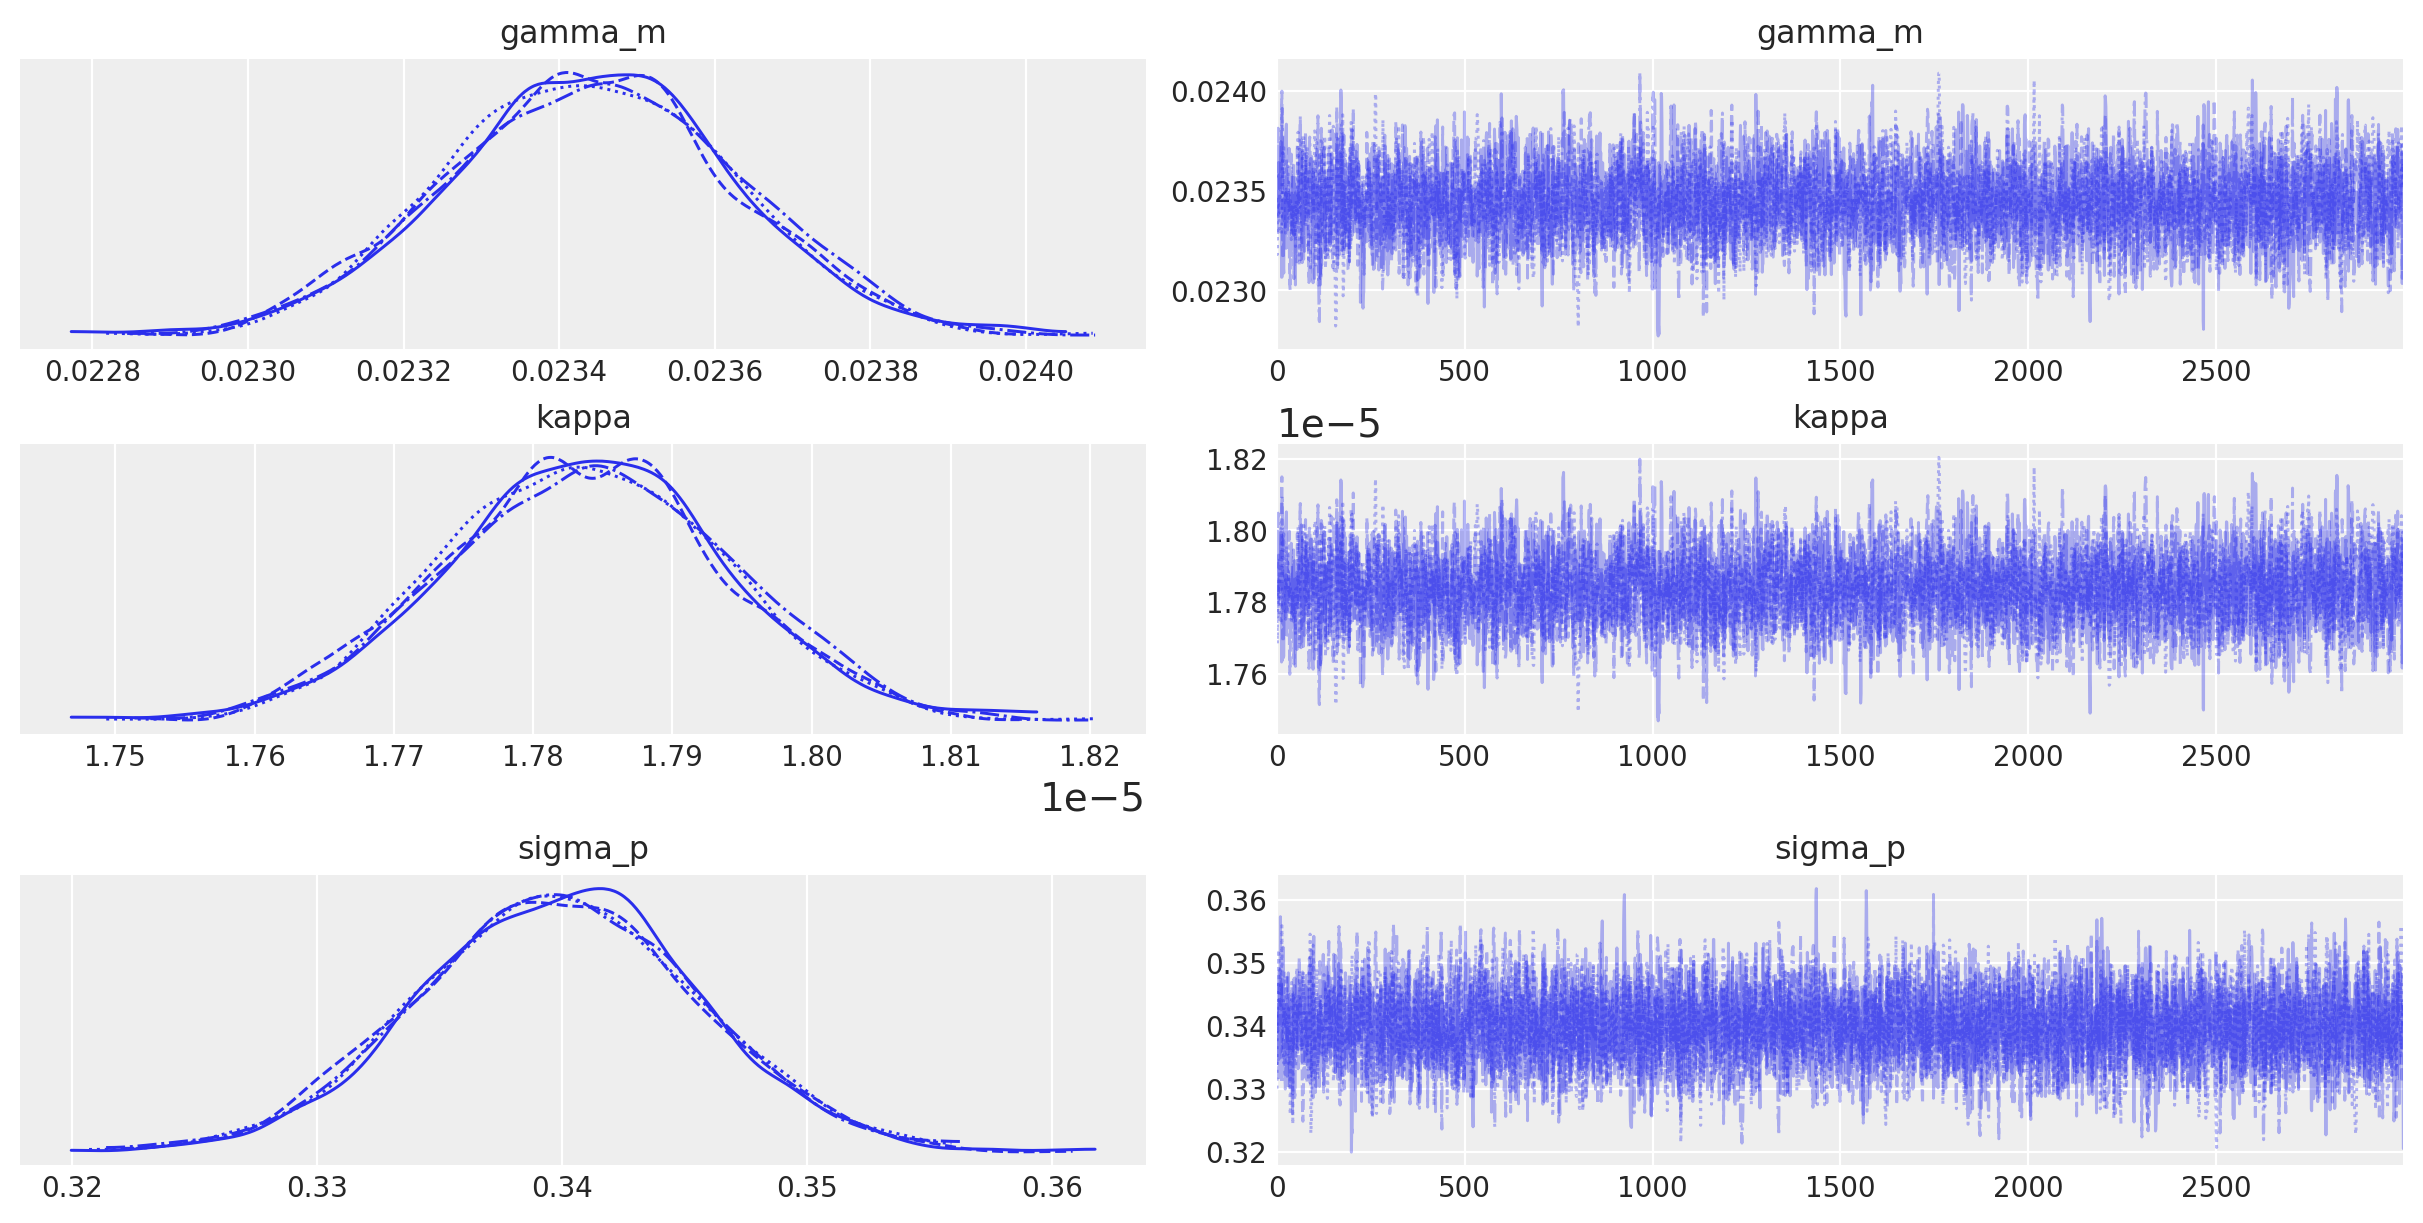

In [50]:
# Visualize the results
az.plot_trace(idata)

array([[<Axes: ylabel='gamma_m'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='kappa'>, <Axes: >, <Axes: >],
       [<Axes: xlabel='gamma_m', ylabel='sigma_p'>,
        <Axes: xlabel='kappa'>, <Axes: xlabel='sigma_p'>]], dtype=object)

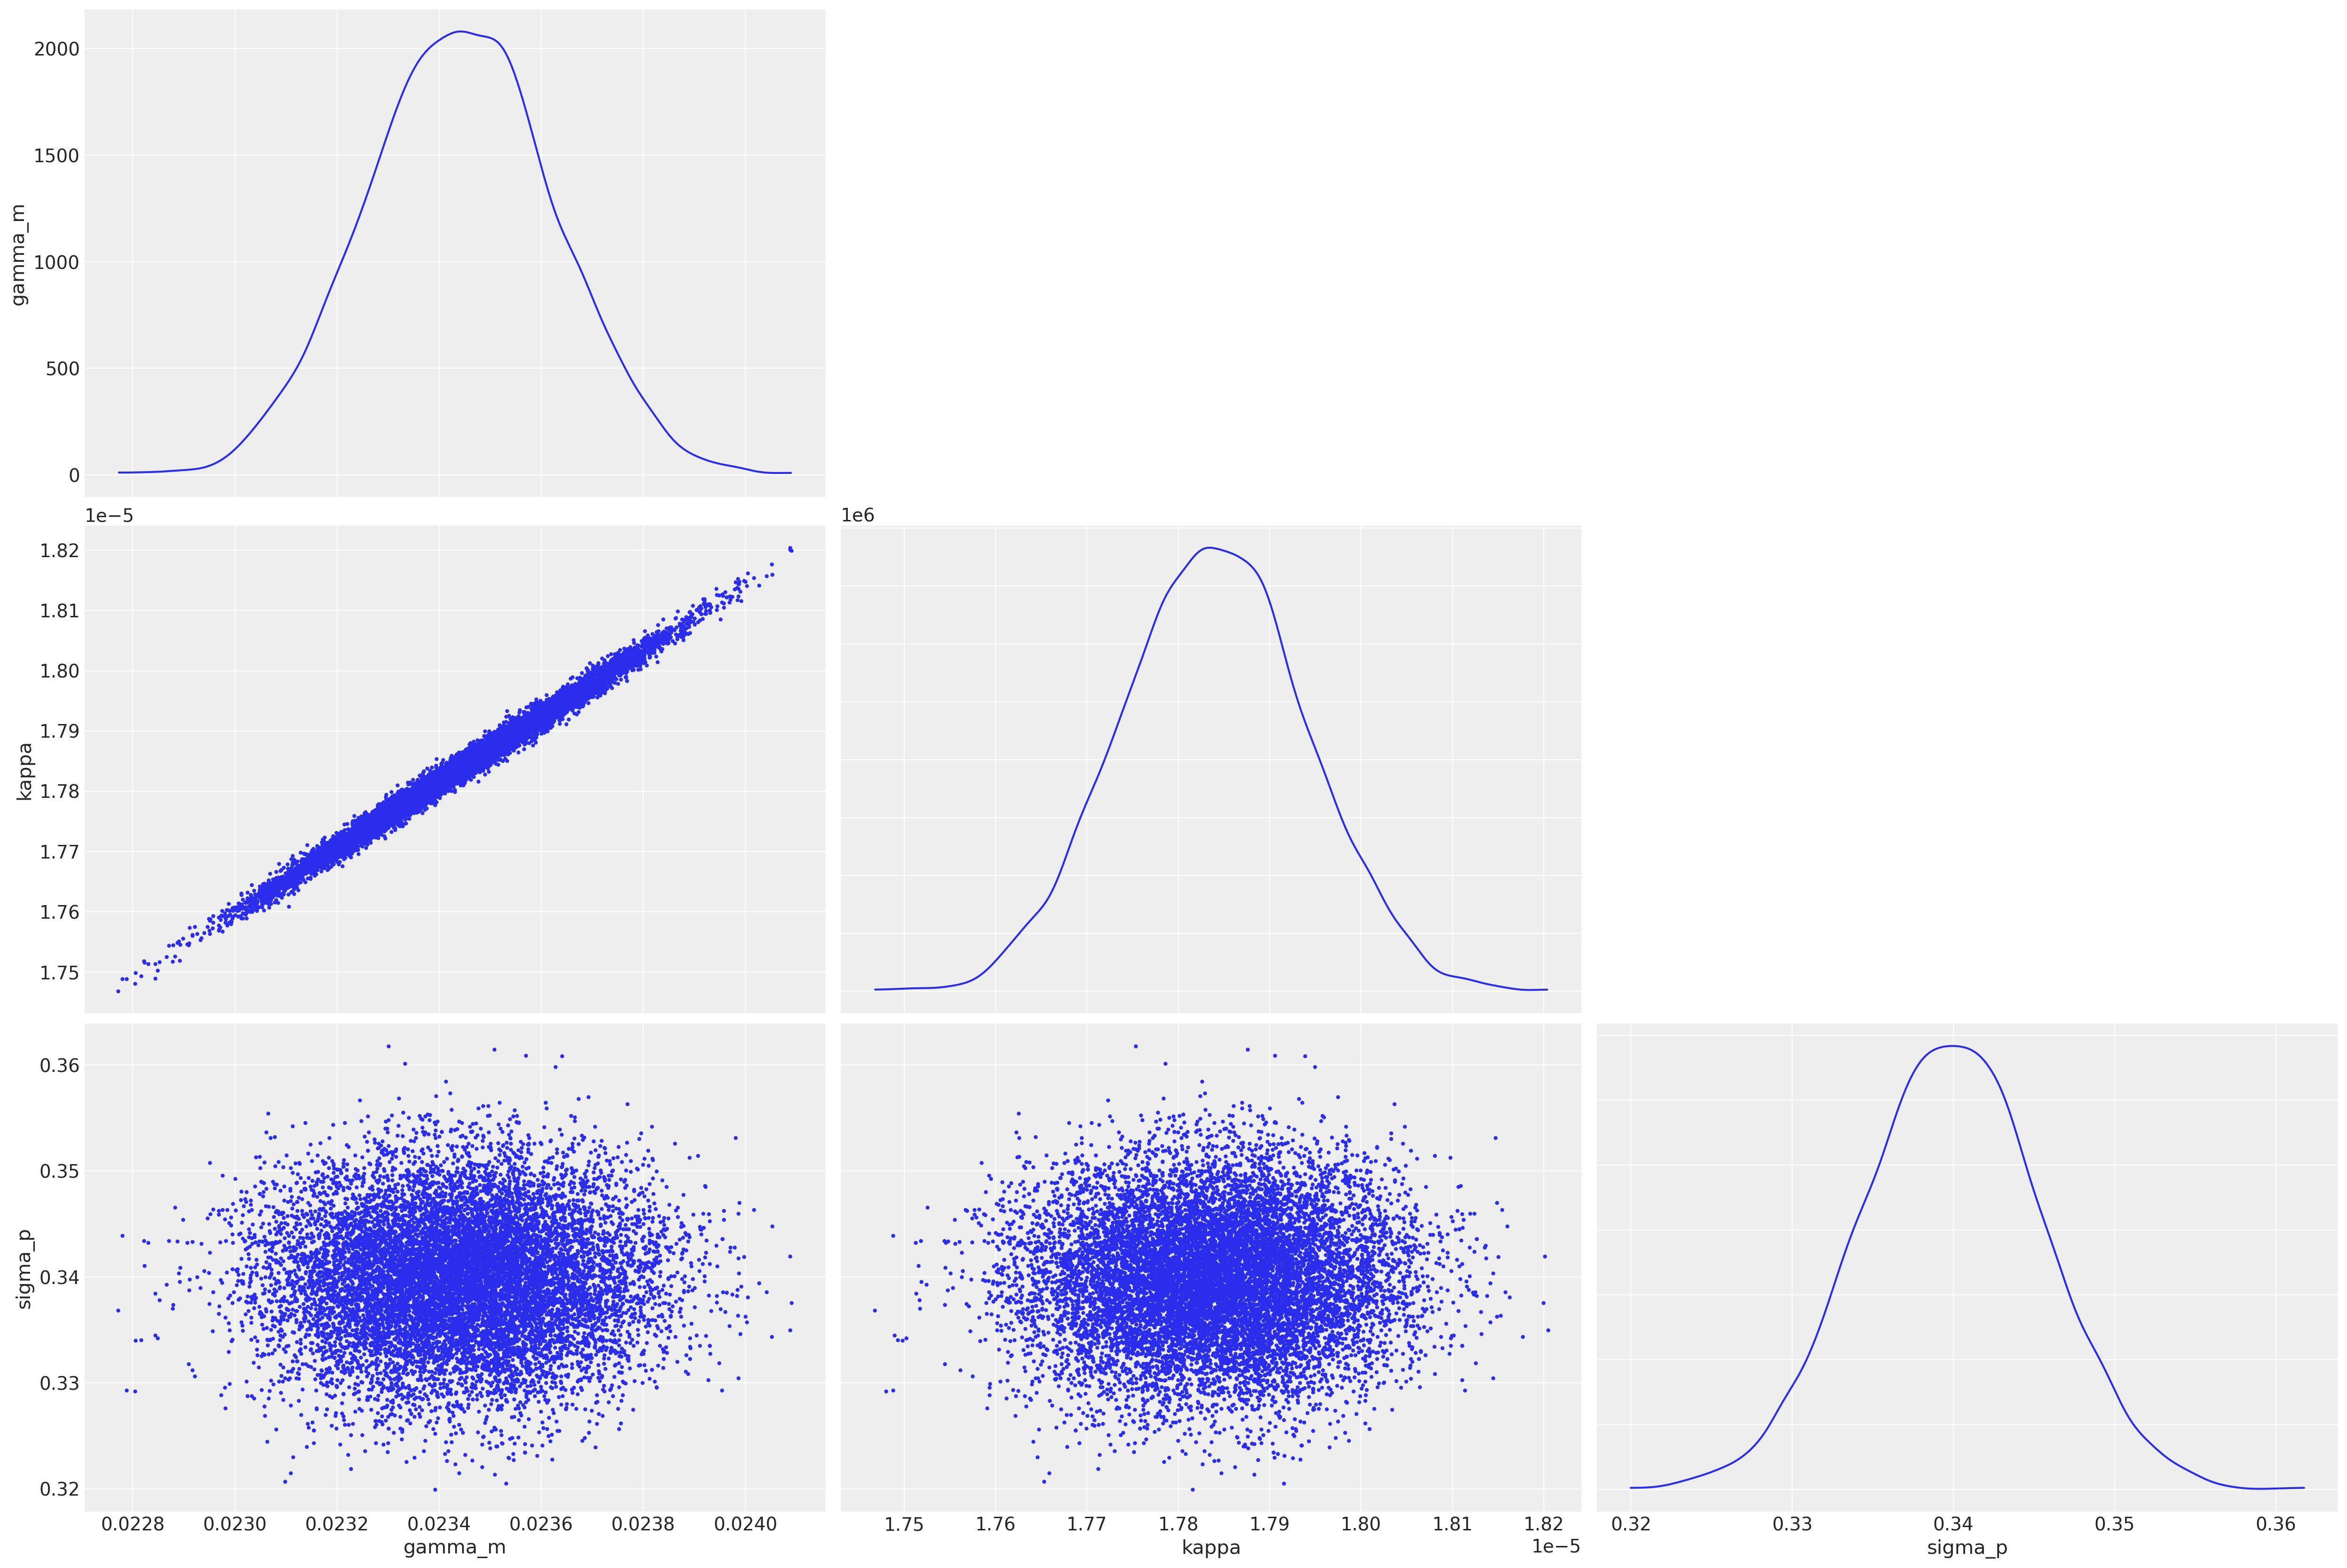

In [51]:
# now let's get a corner plot
az.plot_pair(idata, marginals=True)

In [52]:
def p(t, kappa, gamma_m, D):
    """
    Compute the expected protein level at time `t` given the parameters `kappa`, `gamma_m`,
    and `D`.

    Arguments:
    - t: Time point.
    - kappa: Effective transcription-translation rate.
    - gamma_m: mRNA degradation rate.
    - D: DNA concentration.

    Returns:
    - Protein level at time `t`.
    """
    return (kappa / gamma_m**2) * D * (np.exp(-gamma_m * t) - 1 + gamma_m * t)

In [53]:
# Concatenate samples from all chains
gamma_m_samples = np.concatenate(idata.posterior['gamma_m'].values, axis=0)[:100]
kappa_samples = np.concatenate(idata.posterior['kappa'].values, axis=0)[:100]
sigma_p_samples = np.concatenate(idata.posterior['sigma_p'].values, axis=0)[:100]


# generate an array 'DNA_samples' with the same length as gamma_m_samples, kappa_samples, and sigma_p_samples
DNA_samples = np.full(len(gamma_m_samples), DNA)

len(DNA_samples)

100

In [54]:
sigma_p_samples[2]

0.3407681105231245

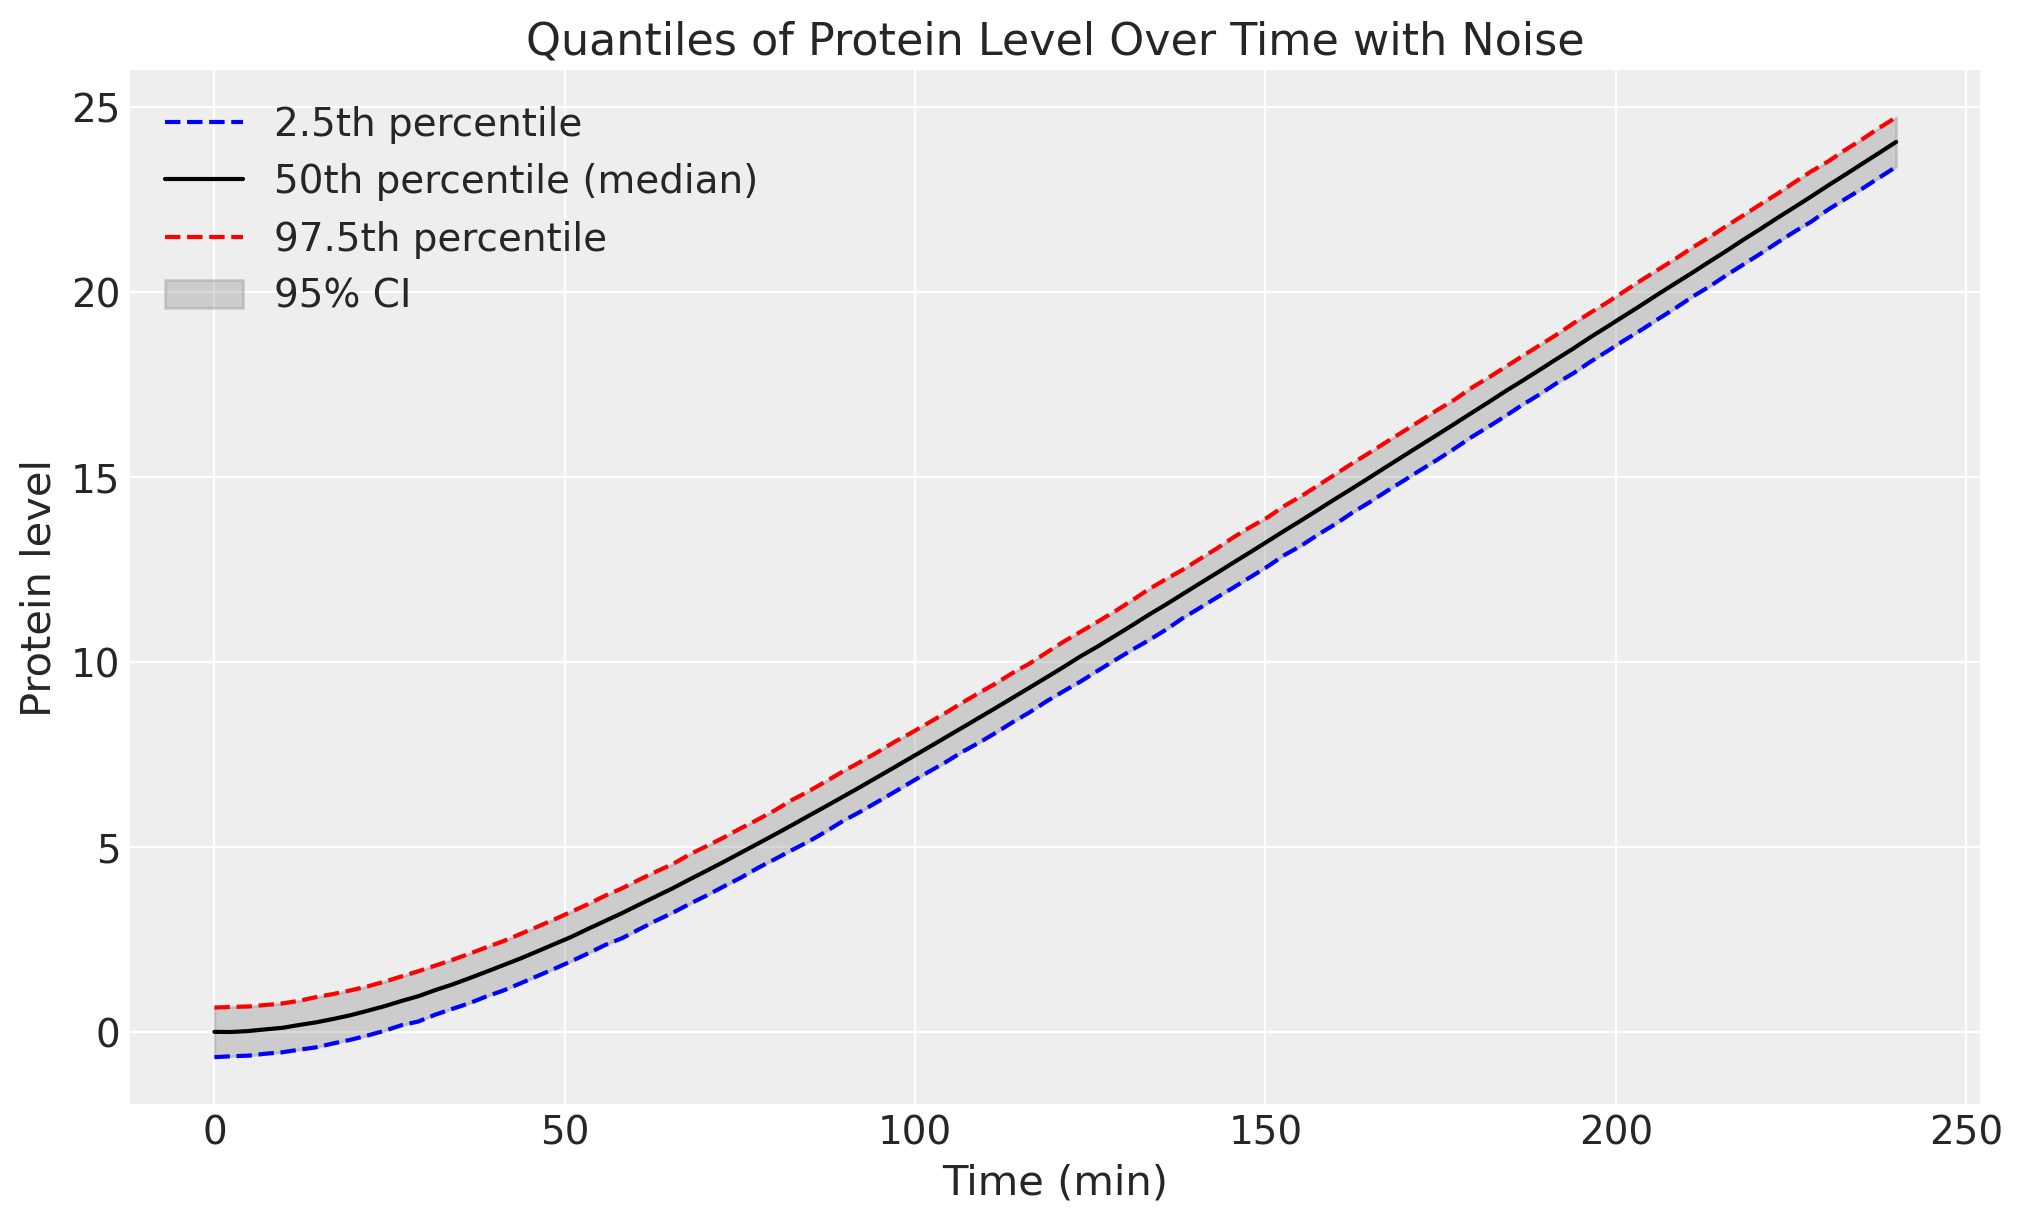

In [55]:
# Concatenate samples from all chains
gamma_m_samples = np.concatenate(idata.posterior['gamma_m'].values, axis=0)
kappa_samples = np.concatenate(idata.posterior['kappa'].values, axis=0)
sigma_p_samples = np.concatenate(idata.posterior['sigma_p'].values, axis=0)

# Generate an array 'DNA_samples' with the same length as gamma_m_samples, kappa_samples, and sigma_p_samples
DNA_samples = np.full(len(gamma_m_samples), DNA)

# Generate time points
t = np.linspace(0, 240, 100)

# Define a vectorized version of the p function
def p_vectorized(t, kappa, gamma_m, D):
    return (kappa / gamma_m**2) * D * (np.exp(-gamma_m * t[:, np.newaxis]) - 1 + gamma_m * t[:, np.newaxis])

# Generate p_samples
p_samples = p_vectorized(t, kappa_samples, gamma_m_samples, DNA_samples)

# Generate noise based on sigma_p_samples
noise = np.random.normal(0, sigma_p_samples, p_samples.shape)

# Add noise to p_samples
p_samples_with_noise = p_samples + noise

# Calculate quantiles with noise
quantiles_with_noise = np.percentile(p_samples_with_noise, [2.5, 50, 97.5], axis=1)

# Plot quantiles with noise
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(t, quantiles_with_noise[0], linestyle='--', color='blue', label='2.5th percentile')
ax.plot(t, quantiles_with_noise[1], linestyle='-', color='black', label='50th percentile (median)')
ax.plot(t, quantiles_with_noise[2], linestyle='--', color='red', label='97.5th percentile')

# Fill between the 2.5th and 97.5th percentiles with noise
ax.fill_between(t, quantiles_with_noise[0], quantiles_with_noise[2], color='gray', alpha=0.3, label='95% CI')

ax.set_xlabel('Time (min)')
ax.set_ylabel('Protein level')
ax.set_title('Quantiles of Protein Level Over Time with Noise')
ax.legend()
plt.show()

In [32]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Assuming protein_posteriors is a 3D array with shape (time_points, num_kappa_samples, num_gamma_m_samples)
# # Assuming t is a 1D array representing time points

# # Get the number of kappa and gamma_m samples
# num_kappa_samples = protein_posteriors.shape[1]
# num_gamma_m_samples = protein_posteriors.shape[2]

# # Initialize the plot
# fig, ax = plt.subplots(figsize=(10, 6))

# # Plot the protein levels for all samples
# for k_idx in range(num_kappa_samples):
#     for g_idx in range(num_gamma_m_samples):
#         ax.plot(t, protein_posteriors[:, k_idx, g_idx], label=f'Sample {k_idx}-{g_idx}')

# # Add labels and legend
# ax.set_xlabel('Time (a.u.)')
# ax.set_ylabel('Protein level (a.u.)')
# ax.set_title('Protein Level Over Time for All Samples')
# ax.legend()

# # Display the plot
# plt.show()